# 2025 2학기 기계학습기초 '사용자 댓글 기반 소셜 반응 시각화 모델' 팀

이 문서에서는 PyTorch를 사용하여 BERT 모델을 구현한 과정을 다룹니다.

## 1. BERT 모델 구현을 위한 데이터 전처리 파일 가져오기

### 1.1 구글 드라이브 접근
[Hugging Face의 dair-ai/emotion 데이터셋](https://huggingface.co/datasets/dair-ai/emotion)을 이용해 팀원이 만든 model과 vocab을 구글 드라이브에 저장한 뒤 마운트하여 사용할 수 있습니다.

우선 아래 코드를 실행시켜 허용을 눌러주면, 왼쪽 '파일'에 내 구글 드라이브가 마운트 됩니다.
이를 확인해보세요.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


이후 [BERT 구현에 사용할 전처리된 데이터 model, vocab](https://github.com/Jinius36/creator-comment-emotion-classifier/tree/main/bert-implementation/data-preprocessing)에서 파일을 다운로드 하여 내 구글 드라이브에 저장하고, 저장한 장소로 아래 디렉토리를 수정해주세요.

In [2]:
data_dir = "/content/drive/MyDrive/bert"

이제 잘 마운트 되었는지 아래 코드를 실행시켜 확인해봅시다.

In [3]:
import os
for f in os.listdir(data_dir):
  print(f)

mini_emotion_tokenizer_11k.model
mini_emotion_tokenizer_11k.vocab
mini_emotion_tokenizer_7k.model
mini_emotion_tokenizer_7k.vocab
.ipynb_checkpoints


### 1.2 마운트한 Vocab 확인하기
가져온 vocab을 로딩해봅시다.

In [4]:
import sentencepiece as spm

# vocab loading
vocab_file = f"{data_dir}/mini_emotion_tokenizer_7k.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

### 1.3 프로젝트 시작 전 Import 하기

In [5]:
!pip install wget

In [6]:
import os
import numpy as np
import math
from random import random, randrange, randint, shuffle, choice
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F

## 2. BERT 모델 개요

구글이 [2018년 발표한 BERT 논문](https://arxiv.org/pdf/1810.04805)에서 제안된 모델의 구조는 이렇습니다.
<p>
<img src="https://raw.githubusercontent.com/Jinius36/creator-comment-emotion-classifier/main/bert-implementation/colab/bert-outline-diagram.png" width = "30%"/>
</p>


구조를 확인해보면, 표준 Transformer 모델에서 EncoderLayer 부분은 동일하게 가져오되 Encoder 부분에서 token, position 외에 'segment embedding'을 추가해야 함을 확인할 수 있습니다.   

또한, BERT 모델의 파라미터는 Base 모델과 Large 모델로 다음과 같음을 확인하였습니다.   
| **파라미터 종류**         | **BERT-Base** | **BERT-Large** |
|---------------------------|---------------|----------------|
| Layer 수                  | 12            | 24             |
| Embedding 차원            | 768           | 1024           |
| Self-Attention Head 수    | 12            | 16             |
| Feed-Forward 차원         | 3072          | 4096           |
| 총 파라미터 수            | 약 1억 1천만  | 약 3억 4천만   |
| 최대 입력 토큰 수         | 512           | 512            |
| Vocabulary 크기           | 30522         | 30522          |

## 3. config 제작
이번 BERT 모델 구현은 다음과 같이 설정하여 진행해보겠습니다.   
| **파라미터 종류**           | **나의 BERT 구성** |
| --------------------- | -------------- |
| Layer 수               | 6              |
| Embedding 차원          | 256            |
| Self-Attention Head 수 | 4              |
| Feed-Forward 차원       | 1024           |
| 총 입력 문장 수 (훈련셋)       | 436,809        |
| 최대 입력 토큰 수            | 256            |
| Vocabulary 크기         | 7[링크 텍스트](https://),000         |
| Segment Type 수        | 2              |
| Dropout               | 0.1            |
| LayerNorm Epsilon     | 1e-12          |
| Pad Token Index       | 0              |

이는 우리 팀에서 구현하는 BERT 모델의 기본 모델이며,
추후 성능 테스트를 진행할 때 config를 수정하여 모델을 수정해볼 수도 있도록 하였습니다.

In [7]:
# configuration을 읽어들이는 class
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [8]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_seg_type": 2,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 7000, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


## 4. 공통 함수
표준 Transformer에서 공통으로 사용되는 함수와 클래스를 정의해놓았습니다.

```
# 코드로 형식 지정됨
```



In [9]:
# 위치 인코딩 생성 함수 (Sinusoidal 방식)
def create_sinusoidal_position_encoding(n_seq, d_hidn):
    """
    Sinusoidal 방식의 위치 인코딩 테이블 생성

    Args:
        n_seq (int): 최대 시퀀스 길이
        d_hidn (int): 임베딩 차원 수

    Returns:
        np.ndarray: [n_seq, d_hidn] 위치 인코딩 매트릭스
    """
    def get_angle(pos, i):
        return pos / np.power(10000, 2 * (i // 2) / d_hidn)

    table = np.array([
        [get_angle(pos, i) for i in range(d_hidn)]
        for pos in range(n_seq)
    ])
    table[:, 0::2] = np.sin(table[:, 0::2])
    table[:, 1::2] = np.cos(table[:, 1::2])
    return table

# 어텐션 마스크 생성 (패딩 토큰에 대한 마스크)
def create_padding_mask(seq_q, seq_k, pad_idx):
    """
    패딩 토큰에 대한 어텐션 마스크 생성

    Args:
        seq_q (Tensor): Query 시퀀스 [batch_size, seq_len_q]
        seq_k (Tensor): Key 시퀀스 [batch_size, seq_len_k]
        pad_idx (int): 패딩 토큰 인덱스

    Returns:
        Tensor: [batch_size, seq_len_q, seq_len_k] 마스크 텐서
    """
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    mask = seq_k.eq(pad_idx).unsqueeze(1).expand(batch_size, len_q, len_k)
    return mask

# 디코더용 어텐션 마스크 생성 (미래 토큰 가리기)
def create_look_ahead_mask(seq):
    """
    디코더에서 미래 토큰을 가리기 위한 마스크 생성

    Args:
        seq (Tensor): 시퀀스 텐서 [batch_size, seq_len]

    Returns:
        Tensor: [batch_size, seq_len, seq_len] 상삼각 행렬 마스크
    """
    size = seq.size(1)
    mask = torch.ones_like(seq).unsqueeze(-1).expand(-1, size, size)
    return mask.triu(1)

# Scaled Dot-Product Attention
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.scale = 1 / (config.d_head ** 0.5)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, Q, K, V, mask):
        """
        어텐션 확률 계산 및 문맥 벡터 생성

        Args:
            Q, K, V (Tensor): Query, Key, Value 행렬
            mask (Tensor): 어텐션 마스크 [batch, head, q_len, k_len]

        Returns:
            context: 문맥 벡터
            attn: 어텐션 확률
        """
        scores = torch.matmul(Q, K.transpose(-1, -2)) * self.scale
        scores.masked_fill_(mask, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        context = torch.matmul(attn, V)
        return context, attn

# Multi-Head Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.W_Q = nn.Linear(config.d_hidn, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_hidn, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_hidn, config.n_head * config.d_head)
        self.scaled_attn = ScaledDotProductAttention(config)
        self.linear = nn.Linear(config.n_head * config.d_head, config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, Q, K, V, mask):
        """
        어텐션 연산 수행 및 출력을 합치는 과정

        Returns:
            output: [batch, seq_len, d_hidn]
            attn: [batch, head, seq_len, seq_len]
        """
        B = Q.size(0)
        q_s = self.W_Q(Q).view(B, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        k_s = self.W_K(K).view(B, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        v_s = self.W_V(V).view(B, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        mask = mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)
        context, attn = self.scaled_attn(q_s, k_s, v_s, mask)
        context = context.transpose(1, 2).contiguous().view(B, -1, self.config.n_head * self.config.d_head)
        output = self.linear(context)
        return self.dropout(output), attn

# Position-wise Feed Forward Network (1x1 Conv 사용)
class PositionwiseFeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.conv1 = nn.Conv1d(config.d_hidn, config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(config.d_ff, config.d_hidn, kernel_size=1)
        self.activation = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        """
        Conv1D -> GELU -> Conv1D -> Dropout

        Args:
            x (Tensor): [batch, seq_len, d_hidn]

        Returns:
            Tensor: [batch, seq_len, d_hidn]
        """
        x = self.conv1(x.transpose(1, 2))
        x = self.activation(x)
        x = self.conv2(x).transpose(1, 2)
        return self.dropout(x)

## 5. Encoder 구현
이제 표준 Transformer Encoder를 수정하여 Encoder를 구현해보겠습니다.
<p>
<img src="https://raw.githubusercontent.com/Jinius36/creator-comment-emotion-classifier/main/bert-implementation/colab/Figure-2-in-BERT-paper.png"/>
</p>
<caption>
Figure 2. BERT의 입력 임베딩 구성 방식. 토큰 임베딩, 세그먼트 임베딩, 위치 임베딩의 합으로 구성됨.  
출처: Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*. arXiv preprint arXiv:1810.04805.
</caption>

위 Figure 2에서 확인할 수 있듯 표준 Transformer Encoder에 'Segment Embeddings'를 추가하여 구현해야 합니다.   
구현한 코드는 아래와 같습니다.

In [10]:
# Self-Attention 인코더 블록 정의
class SelfAttentionEncoderBlock(nn.Module):
    """
    인코더 블록: Multi-Head Attention과 Feed-Forward Network를 포함하며,
    각각의 출력에는 Residual Connection과 Layer Normalization이 적용됩니다.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        # 다중 자기 주의 메커니즘
        self.multi_head_attn = MultiHeadSelfAttention(config)
        # 첫 번째 Layer Normalization
        self.norm_after_attn = nn.LayerNorm(config.d_hidn, eps=config.layer_norm_epsilon)
        # 위치 기반 FeedForward Network
        self.feed_forward = PositionwiseFeedForward(config)
        # 두 번째 Layer Normalization
        self.norm_after_ffn = nn.LayerNorm(config.d_hidn, eps=config.layer_norm_epsilon)

    def forward(self, x, attn_mask):
        # 자기 주의 연산 및 attention 확률 반환
        attn_output, attn_weights = self.multi_head_attn(x, x, x, attn_mask)
        # 첫 번째 잔차 연결 및 정규화
        x = self.norm_after_attn(x + attn_output)
        # Feed Forward 통과 후 두 번째 잔차 연결 및 정규화
        ffn_output = self.feed_forward(x)
        x = self.norm_after_ffn(x + ffn_output)

        return x, attn_weights

# 전체 Transformer 인코더 정의
class TransformerEncoder(nn.Module):
    """
    Transformer Encoder 전체 구성:
    임베딩(토큰, 위치, 세그먼트) 후 다수의 인코더 블록을 순차적으로 통과합니다.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        # 토큰 임베딩, 위치 임베딩, 세그먼트 임베딩 정의
        self.token_embedding = nn.Embedding(config.n_enc_vocab, config.d_hidn)
        self.position_embedding = nn.Embedding(config.n_enc_seq + 1, config.d_hidn)
        self.segment_embedding = nn.Embedding(config.n_seg_type, config.d_hidn)

        # 인코더 블록 여러 층 정의
        self.encoder_blocks = nn.ModuleList([
            SelfAttentionEncoderBlock(config) for _ in range(config.n_layer)
        ])

    def forward(self, token_ids, segment_ids):
        # 위치 인덱스 생성 (패딩은 0으로 마스킹)
        seq_length = token_ids.size(1)
        device = token_ids.device
        position_ids = torch.arange(seq_length, dtype=torch.long, device=device).unsqueeze(0).expand_as(token_ids) + 1
        position_ids = position_ids.masked_fill(token_ids.eq(self.config.i_pad), 0)

        # 세 가지 임베딩의 합산
        x = (
            self.token_embedding(token_ids)
            + self.position_embedding(position_ids)
            + self.segment_embedding(segment_ids)
        )

        # 패딩 마스크 생성
        attn_mask = create_padding_mask(token_ids, token_ids, self.config.i_pad)

        all_attention_weights = []
        for block in self.encoder_blocks:
            x, attn_weights = block(x, attn_mask)
            all_attention_weights.append(attn_weights)

        return x, all_attention_weights

## 6. BERT 구현
이제 BERT 모델을 구현해보겠습니다.

BERTModel 클래스의 각 함수를 설명해보면 다음과 같습니다.   
- init에서 위에서 만든 ransformerEncoder를 실행하여 전체 문장의 Contextual Embedding을 생성합니다.   
- forward에서 Encoder의 출력 중 첫 번째 위치의 토큰([CLS]) 벡터를 cls_output으로 추출하고,    
추출한 [CLS] 벡터에 대해 선형 변환과 tanh 활성화를 적용하여 문장 표현을 완성합니다.   
- save 함수는 학습 epoch, loss, 모델 가중치를 지정된 경로에 저장하며,   
 load 함수는 저장된 모델 상태를 로드해 학습이 중단된 epoch과 loss를 반환합니다.

In [11]:
class BERTModel(nn.Module):
    """
    BERT 모델 정의:
    - Transformer Encoder를 기반으로 [CLS] 벡터를 추출하여 활용합니다.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        # 인코더 모듈 (Transformer 구조 기반)
        self.encoder = TransformerEncoder(self.config)

        # [CLS] 토큰 출력을 위한 추가 선형 변환 및 활성화 함수
        self.linear_cls = nn.Linear(config.d_hidn, config.d_hidn)
        self.activation_cls = torch.tanh

    def forward(self, input_ids, segment_ids):
        """
        입력:
          - input_ids: 토큰 ID 시퀀스 (batch_size, n_seq)
          - segment_ids: 세그먼트 정보 (batch_size, n_seq)

        출력:
          - 전체 인코더 출력 (contextual embeddings)
          - [CLS] 토큰 출력 (문장 표현)
          - 각 층별 attention 가중치 리스트
        """
        # 인코더를 통과시켜 contextual embedding 획득
        encoder_output, attention_weights = self.encoder(input_ids, segment_ids)

        # 문장 수준 표현을 위한 [CLS] 토큰 벡터 추출 및 변환
        cls_output = encoder_output[:, 0].contiguous()
        cls_output = self.linear_cls(cls_output)
        cls_output = self.activation_cls(cls_output)

        return encoder_output, cls_output, attention_weights

    def save(self, epoch, loss, path):
        """
        모델 저장 함수
        """
        torch.save({
            "epoch": epoch,
            "loss": loss,
            "state_dict": self.state_dict()
        }, path)

    def load(self, path):
        """
        저장된 모델 로드 함수
        """
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint["state_dict"])
        return checkpoint["epoch"], checkpoint["loss"]

## 7. BERT Pretrain class 개요 및 구현
BERT는 Transformer Encoder를 기반으로 한 비생성형 사전학습 모델입니다.
Transformer의 생성형 학습 방식과는 달리, BERT는 양방향 문맥 이해에 특화된 사전학습 목표를 사용합니다.

### 사전학습 목표
- Masked Language Modeling (MLM):   
  입력 문장에서 일부 토큰을 [MASK]로 가리고 해당 마스크된 위치의 원래 단어를 예측하는 과제
- Next Sentence Prediction (NSP):   
  두 문장이 주어졌을 때 두 번째 문장이 실제 다음 문장인지 이진 분류하는 과제

### 구현 개요
- BERT 인코더의 출력(Contextual Embeddings)을 바탕으로   
MLM과 NSP를 위한 두 개의 출력 레이어를 구성합니다.
- 이 출력값들을 통해 각각의 손실(loss) 을 계산하고,   
두 손실을 합산하여 모델을 학습시켰습니다.

In [12]:
# BERT 사전학습을 위한 모델 클래스 정의
class BERTPretrain(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # BERT 인코더 모델 불러오기
        self.bert = BERTModel(self.config)

        # NSP (다음 문장 예측)를 위한 이진 분류기 정의
        self.projection_cls = nn.Linear(self.config.d_hidn, 2, bias=False)

        # MLM (마스크된 단어 예측)를 위한 출력 계층 정의
        self.projection_lm = nn.Linear(self.config.d_hidn, self.config.n_enc_vocab, bias=False)

        # 입력 임베딩 레이어와 출력 계층의 가중치 공유 (Weight Tying)
        # self.bert.encoder 내부의 token_embedding을 참조
        self.projection_lm.weight = self.bert.encoder.token_embedding.weight

    def forward(self, token_ids, segment_ids):
        # BERT 인코더를 통과하여 전체 문맥 벡터, [CLS] 벡터, 어텐션 확률을 가져옴
        sequence_output, cls_output, attn_weights = self.bert(token_ids, segment_ids)

        # NSP 예측: [CLS] 토큰 벡터를 분류기에 입력하여 두 문장이 연속인지 판단
        logits_cls = self.projection_cls(cls_output)

        # MLM 예측: 모든 토큰 위치에서 원래 단어를 예측
        logits_lm = self.projection_lm(sequence_output)

        # 각 태스크에 대한 출력값 반환
        return logits_cls, logits_lm, attn_weights

### 7.1 MLM을 위한 마스크 생성 함수

In [13]:
# 마스킹된 토큰을 생성하는 함수
def generate_masked_tokens(tokens, mask_cnt, vocab_list):
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    shuffle(cand_idx)

    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        for index in index_set:
            masked_token = None
            if random() < 0.8: # 80% replace with [MASK]
                masked_token = "[MASK]"
            else:
                if random() < 0.5: # 10% keep original
                    masked_token = tokens[index]
                else: # 10% random word
                    masked_token = choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

### 7.2 NSP용 인스턴스 및 전체 pretrain 데이터 생성 함수

In [14]:
# 두 문장의 길이를 맞추기 위해 자르는 함수
def trim_sequences(seq_a, seq_b, max_total_length):
    while True:
        total_length = len(seq_a) + len(seq_b)
        if total_length <= max_total_length:
            break

        if len(seq_a) > len(seq_b):
            del seq_a[0]
        else:
            seq_b.pop()

# BERT 사전학습용 인스턴스를 생성하는 함수
def generate_pretrain_instances(docs, doc_idx, doc, n_seq, mask_prob, vocab_list):
    max_seq = n_seq - 3  # [CLS], [SEP], [SEP]
    tgt_seq = max_seq

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i]) # line
        current_length += len(doc[i])
        if i == len(doc) - 1 or current_length >= tgt_seq:
            if 0 < len(current_chunk):
                a_end = 1
                if 1 < len(current_chunk):
                    a_end = randrange(1, len(current_chunk))
                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])

                tokens_b = []
                if len(current_chunk) == 1 or random() < 0.5:
                    is_next = 0
                    tokens_b_len = tgt_seq - len(tokens_a)
                    random_doc_idx = doc_idx
                    while doc_idx == random_doc_idx:
                        random_doc_idx = randrange(0, len(docs))
                    random_doc = docs[random_doc_idx]

                    random_start = randrange(0, len(random_doc))
                    for j in range(random_start, len(random_doc)):
                        tokens_b.extend(random_doc[j])
                else:
                    is_next = 1
                    for j in range(a_end, len(current_chunk)):
                        tokens_b.extend(current_chunk[j])

                trim_sequences(tokens_a, tokens_b, max_seq)
                assert 0 < len(tokens_a)
                assert 0 < len(tokens_b)

                tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
                segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

                tokens, mask_idx, mask_label = generate_masked_tokens(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

                instance = {
                    "tokens": tokens,
                    "segment": segment,
                    "is_next": is_next,
                    "mask_idx": mask_idx,
                    "mask_label": mask_label
                }
                instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

### 7.3 Pretrain 데이터 생성

In [15]:
# 감정 데이터셋
ds = load_dataset("dair-ai/emotion", split="train")
docs = [[vocab.encode_as_pieces(row["text"])] for row in ds]

# Pretrain 데이터 생성 함수
def build_pretrain_dataset_from_docs(docs, vocab, output_path_template, num_files, seq_length, mask_ratio):
    vocab_tokens = [vocab.id_to_piece(i) for i in range(vocab.get_piece_size()) if not vocab.is_unknown(i)]
    for i in range(num_files):
        output_file = output_path_template.format(i)
        if os.path.exists(output_file):
            print(f"[경고] {output_file} 파일이 이미 존재하여 덮어씁니다.")
            os.remove(output_file)

        total_written = 0
        with open(output_file, "w") as out_f:
            for doc_idx, doc in enumerate(tqdm(docs, desc=f"Creating File {i}")):
                inst_list = generate_pretrain_instances(docs, doc_idx, doc, seq_length, mask_ratio, vocab_tokens)
                for inst in inst_list:
                    out_f.write(json.dumps(inst) + "\n")
                    total_written += 1
        print(f"[완료] {output_file}: {total_written}개 instance 저장 완료")

# 실행
build_pretrain_dataset_from_docs(
    docs,
    vocab,
    output_path_template="/content/drive/MyDrive/bert/emotion_bert_pretrain_{:02d}.json",
    num_files=1,
    seq_length=256,
    mask_ratio=0.15
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Creating File 0: 100%|██████████| 16000/16000 [00:02<00:00, 5793.40it/s]

[완료] /content/drive/MyDrive/bert/emotion_bert_pretrain_00.json: 16000개 instance 저장 완료


데이터가 잘 생성되었는지 확인해봅시다.

In [16]:
# 출력 파일 경로
out_file = f"{data_dir}/emotion_bert_pretrain_00.json"

# 1. 파일 존재 여부 확인
file_exists = os.path.exists(out_file)

# 2. 파일 내용 확인
if file_exists:
    with open(out_file, "r") as f:
        lines = f.readlines()
        line_count = len(lines)
        # 첫 번째 인스턴스 로드
        first_instance = json.loads(lines[0]) if line_count > 0 else {}

        # 필수 키 확인
        required_keys = {"tokens", "segment", "is_next", "mask_idx", "mask_label"}
        missing_keys = [key for key in required_keys if key not in first_instance]
        all_keys_present = len(missing_keys) == 0
else:
    line_count = 0
    first_instance = {}
    missing_keys = list({"tokens", "segment", "is_next", "mask_idx", "mask_label"})
    all_keys_present = False

# 결과 출력
print("파일 존재 여부:", file_exists)
print("인스턴스 개수:", line_count)
print("첫 번째 인스턴스:", first_instance)
print("누락된 키:", missing_keys)
print("모든 키 존재 여부:", all_keys_present)

파일 존재 여부: True
인스턴스 개수: 16000
첫 번째 인스턴스: {'tokens': ['[CLS]', '[MASK]', '▁didnt', '▁feel', '▁humiliated', '[SEP]', '▁i', '▁will', '▁remember', '▁you', '▁as', '▁someone', '[MASK]', '▁i', '▁could', '▁feel', '▁so', '▁comfortable', '▁around', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [1, 12], 'mask_label': ['▁i', '▁who']}
누락된 키: []
모든 키 존재 여부: True


### 7.4 감정 분석 BERT Pretrain Dataset 구성

#### 7.4.1 EmotionPretrainDataset 클래스(MLM을 위한 라벨 구성)

이 클래스는 감정 분석용 BERT 모델을 사전학습(pretrain)하기 위한 데이터셋을 정의합니다.

입력 파일(emotion_bert_pretrain_00.json)을 한 줄씩 읽으며 다음과 같은 정보를 수집합니다.
- is_next: 두 문장이 실제로 이어지는 문장인지 판단하는 NSP(Next Sentence Prediction) 라벨입니다.
- tokens: 문장을 SentencePiece로 분할한 토큰 리스트입니다.
- segment: 첫 번째 문장은 0, 두 번째 문장은 1로 구분한 세그먼트 정보입니다.
- mask_idx: 마스킹된 토큰의 위치를 나타냅니다.
- mask_label: 마스킹된 토큰이 원래 어떤 단어였는지를 나타내는 정답입니다.

이 정보를 바탕으로 다음을 수행합니다:

1. 문장 토큰들을 vocab의 ID로 변환하여 sentences에 저장합니다.
2. 세그먼트 정보를 segments에 저장합니다.
3. labels_lm이라는 시퀀스를 생성하고, 모든 값은 기본적으로 -1로 채워집니다.
4. 마스킹된 위치(mask_idx)에만 정답(mask_label)을 넣습니다.

In [17]:
class EmotionPretrainDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, input_json_path):
        self.vocab = vocab
        self.labels_cls = []    # NSP (Next Sentence Prediction) 라벨 저장
        self.labels_lm = []     # MLM (Masked Language Model) 라벨 저장
        self.sentences = []     # 토큰 ID로 변환된 문장 시퀀스
        self.segments = []      # 세그먼트 정보 (문장 A=0, 문장 B=1)

        line_count = 0

        # 전체 라인 수 계산
        with open(input_json_path, "r") as f:
            line_count = sum(1 for _ in f)

        # JSONL 파일을 한 줄씩 읽으며 처리
        with open(input_json_path, "r") as f:
            for line in tqdm(f, total=line_count, desc=f"로딩 중: {input_json_path}", unit="줄"):
                instance = json.loads(line)

                # NSP 라벨
                self.labels_cls.append(instance["is_next"])

                # 문장을 토큰 ID로 변환
                sentences = [vocab.piece_to_id(p) for p in instance["tokens"]]
                self.sentences.append(sentences)

                # 세그먼트 정보
                self.segments.append(instance["segment"])

                # MLM 라벨 처리
                mask_idx = np.array(instance["mask_idx"], dtype=int)
                mask_label = np.array([vocab.piece_to_id(p) for p in instance["mask_label"]], dtype=int)

                # 라벨 시퀀스를 -1로 초기화한 후 마스킹 위치만 실제 정답으로 대체
                label_lm = np.full(len(sentences), dtype=int, fill_value=-1)
                label_lm[mask_idx] = mask_label
                self.labels_lm.append(label_lm)


                # 디버깅
                # print("[DEBUG] labels_lm:", label_lm)

    def __len__(self):
        # 모든 항목의 길이가 같아야 함
        assert len(self.labels_cls) == len(self.labels_lm)
        assert len(self.labels_cls) == len(self.sentences)
        assert len(self.labels_cls) == len(self.segments)
        return len(self.labels_cls)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.labels_cls[idx]),     # NSP 라벨
            torch.tensor(self.labels_lm[idx]),      # MLM 라벨
            torch.tensor(self.sentences[idx]),      # 입력 문장
            torch.tensor(self.segments[idx])        # 세그먼트 정보
        )

#### 7.4.2 Collate 함수: emotion_pretrain_collate_fn

이 함수는 DataLoader에서 배치 단위로 데이터를 묶을 때 사용됩니다.   
배치 안의 문장 길이가 다르기 때문에 각 항목에 대해 패딩 처리가 필요합니다.

  - labels_lm: 정답이 없는 부분은 -1로 패딩합니다. (MLM용)
  - inputs: 문장의 토큰 ID는 0으로 패딩합니다. (이 값은 vocab에서 pad_id로 지정된 값입니다.)
  - segments: 문장의 구간 정보도 0으로 패딩합니다.

- labels_cls: NSP용 라벨이며 길이가 1이므로 바로 stack()하여 텐서로 변환합니다.

In [18]:
def emotion_pretrain_collate_fn(batch):
    labels_cls, labels_lm, inputs, segments = list(zip(*batch))

    # MLM 라벨은 -1로 패딩
    labels_lm = torch.nn.utils.rnn.pad_sequence(labels_lm, batch_first=True, padding_value=-1)
    # 입력 시퀀스 및 세그먼트는 0으로 패딩
    inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
    segments = torch.nn.utils.rnn.pad_sequence(segments, batch_first=True, padding_value=0)

    return [
        torch.stack(labels_cls, dim=0),   # NSP 라벨 (batch_size,)
        labels_lm,    # MLM 라벨 (batch_size, seq_len)
        inputs,       # 입력 시퀀스 (batch_size, seq_len)
        segments      # 세그먼트 정보 (batch_size, seq_len)
    ]

#### 7.4.3 DataLoader 정의

위에서 만든 EmotionPretrainDataset과 collate_fn을 기반으로 DataLoader를 생성합니다.

이 emotion_train_loader는 BERT 사전학습(pretraining)에서 사용될 수 있는 학습용 배치 데이터를 제공합니다.

In [19]:
batch_size = 128
json_path = f"{data_dir}/emotion_bert_pretrain_00.json"
emotion_dataset = EmotionPretrainDataset(vocab, json_path)
emotion_train_loader = torch.utils.data.DataLoader(
    emotion_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=emotion_pretrain_collate_fn
)

로딩 중: /content/drive/MyDrive/bert/emotion_bert_pretrain_00.json: 100%|██████████| 16000/16000 [00:02<00:00, 6880.12줄/s]


## 8. Pretrain

### 8.1 한 epoch 학습을 수행하는 함수
이 함수는 BERT Pretrain을 위한 학습 루틴 중, 한 epoch 동안의 모델 학습을 수행하는 함수입니다.   
NSP와 MLM 두 가지 목적을 함께 학습합니다.   
사전학습 데이터가 준비된 상태에서 Epoch 단위로 반복 실행하며, 모델이 문맥을 이해하고 마스킹된 단어를 예측합니다.

In [20]:
# 1 epoch 동안 BERT Pretrain 모델 학습 수행
def train_one_epoch(config, epoch, model, criterion_lm, criterion_cls, optimizer, data_loader):
    loss_log = []  # MLM loss 누적 기록용 리스트
    model.train()  # 모델을 학습 모드로 설정

    with tqdm(total=len(data_loader), desc=f"Train({epoch})") as pbar:
        for step, batch in enumerate(data_loader):
            # 배치 데이터를 GPU 또는 CPU로 이동
            label_cls, label_lm, token_ids, segment_ids = map(lambda x: x.to(config.device), batch)

            # CrossEntropyLoss는 long 타입 필요 → 명시적으로 타입 캐스팅
            label_cls = label_cls.long()
            label_lm = label_lm.long()

            # 옵티마이저의 기울기 초기화
            optimizer.zero_grad()

            # 모델 순전파: NSP, MLM, Attention 출력을 반환
            logits_cls, logits_lm, _ = model(token_ids, segment_ids)

            # NSP Loss 계산 (Binary Classification)
            loss_cls = criterion_cls(logits_cls, label_cls)

            # MLM Loss 계산 (다중 클래스 분류, ignore_index=-1)
            loss_lm = criterion_lm(logits_lm.view(-1, logits_lm.size(-1)), label_lm.view(-1))

            if torch.isnan(logits_lm).any() or torch.isinf(logits_lm).any():
                print("[ERROR] logits_lm contains NaN or Inf")
            if torch.isnan(label_lm).any() or torch.isinf(label_lm).any():
                print("[ERROR] label_lm contains NaN or Inf")

            # 두 개의 Loss를 더해 최종 손실 계산
            total_loss = loss_cls + loss_lm

            # MLM loss만 로깅에 사용
            loss_log.append(loss_lm.item())

            # 역전파 및 가중치 업데이트
            total_loss.backward()
            optimizer.step()

            # 진행 상태 표시
            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_lm.item():.3f} (Avg: {np.mean(loss_log):.3f})")

    # MLM 평균 손실 반환
    return np.mean(loss_log)

### 8.2 전체 학습 실행 코드
아래 구현한 코드는 BERT Pretrain을 여러 epoch에 걸쳐 반복 실행하는 전체 학습 루틴을 정의합니다.   
모델 초기화부터 학습 손실 계산, 모델 저장까지의 모든 과정을 포함합니다.

#### 8.2.1 주요 구성 요소

In [21]:
# 사용할 디바이스 설정 (GPU가 가능하면 CUDA 사용)
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(config)

# 학습 관련 설정
learning_rate = 5e-5
num_epochs = 20

# BERT Pretrain 모델 정의 및 저장 경로
model = BERTPretrain(config)
pretrain_model_path = f"{data_dir}/save_bert_pretrain.pth"

# 기존 저장 모델이 있다면 로드
start_epoch, best_loss = 0, 0
if os.path.isfile(pretrain_model_path):
    start_epoch, best_loss = model.bert.load(pretrain_model_path)
    print(f"[불러오기 완료] epoch={start_epoch}, loss={best_loss:.4f}")
    start_epoch += 1  # 이어서 학습할 수 있도록 epoch 증가

# 모델을 디바이스에 올리기
model.to(config.device)

# Loss 함수 정의
criterion_mlm = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction="mean")  # MLM은 -1 패딩 무시
criterion_nsp = torch.nn.CrossEntropyLoss()  # NSP용 loss

# 옵티마이저 정의 (Adam 사용)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


{'n_enc_vocab': 7000, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda')}


#### 8.2.2 학습 루프 (epoch 단위 반복)

In [22]:
# 학습 루프
train_losses = []
for epoch_offset in range(num_epochs):
    epoch = start_epoch + epoch_offset

    # 1 epoch 학습 수행
    avg_loss = train_one_epoch(
        config, epoch, model,
        criterion_mlm, criterion_nsp,
        optimizer, emotion_train_loader
    )
    train_losses.append(avg_loss)

    # 모델 저장
    model.bert.save(epoch, avg_loss, pretrain_model_path)


Train(19): 100%|██████████| 125/125 [00:31<00:00,  3.99it/s, Loss: 8.136 (Avg: 8.315)]


## 9. Pretrain 손실 시각화 및 확인
이제 마지막으로 아래 코드를 통해 BERT 모델을 pretrain하면서 매 epoch마다 수집된 손실 값을 표와 그래프로 확인해보며 BERT 모델 구현 및 생성을 완료합니다.

,Epoch,Loss
0,1,29.917206
1,2,20.096656
2,3,17.804081
3,4,16.227823
4,5,15.055319
5,6,14.087969
6,7,13.272986
7,8,12.574113
8,9,11.953634
9,10,11.409157


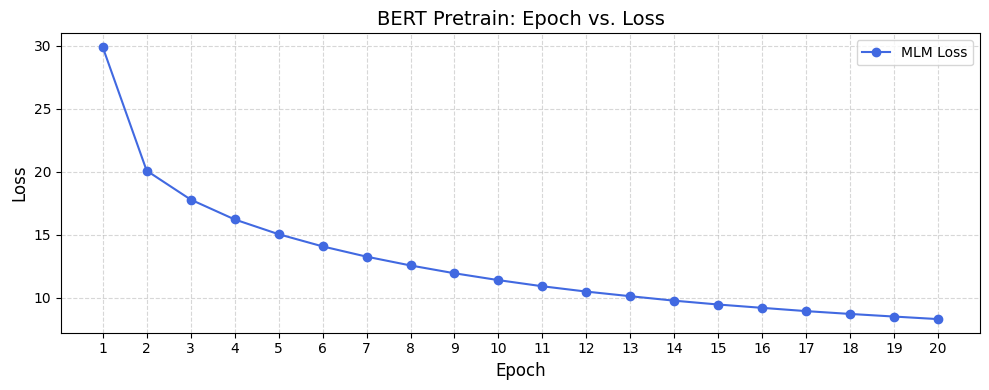

In [23]:
# 손실 값을 DataFrame으로 정리
df = pd.DataFrame({
    "Epoch": list(range(1, len(train_losses) + 1)),
    "Loss": train_losses
})

# 표 형태로 손실 확인
display(df)

# 손실 추이 시각화
plt.figure(figsize=(10, 4))
plt.plot(df["Epoch"], df["Loss"], marker='o', linestyle='-', color='royalblue', label="MLM Loss")
plt.title("BERT Pretrain: Epoch vs. Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(df["Epoch"])
plt.legend()
plt.tight_layout()
plt.show()

## 추가 1. Fine-tuning을 위한 파일 전달

“Hugging Face 호환 포맷”으로 모델을 내보내려고 합니다.   
지금은 모델이 .pth로만 저장되어 있는데, fine-tuning 담당자가 Trainer로 모델을 불러올 수 있게 하려면   
config.json + pytorch_model.bin 구조의 폴더를 전달해줘야 합니다.

In [28]:
from transformers import BertConfig, BertModel

# 전제:
# - vocab: mini_emotion_tokenizer_7k.model 로드한 SentencePieceProcessor
# - config: 7k BERT 학습에 사용한 Config (위에 print(config) 나온 것)
# - model: 해당 config로 학습 완료된 BERTPretrain 인스턴스 (model.bert 존재)

# 1. 저장할 폴더 경로 설정
output_dir = os.path.join(data_dir, "mini_bert_7k_hf")
os.makedirs(output_dir, exist_ok=True)

# 2. Hugging Face용 config.json 생성
#    기존 config 값들을 HF BertConfig에 매핑
config_7k = Config({
    **dict(config),                 # 기존 설정 복사
    "n_enc_vocab": vocab.get_piece_size()
})

hf_config = BertConfig(
    vocab_size=config_7k.n_enc_vocab,
    hidden_size=config_7k.d_hidn,               # hidden size
    num_hidden_layers=config_7k.n_layer,        # encoder layer 수
    num_attention_heads=config_7k.n_head,       # attention head 수
    intermediate_size=config_7k.d_ff,           # FFN 차원
    hidden_dropout_prob=config_7k.dropout,
    attention_probs_dropout_prob=config_7k.dropout,
    max_position_embeddings=config_7k.n_enc_seq,
    type_vocab_size=config_7k.n_seg_type,
    pad_token_id=config_7k.i_pad,
    layer_norm_eps=config_7k.layer_norm_epsilon
)

hf_config.save_pretrained(output_dir)

# 3. 가중치 저장 (encoder 부분만)
# Hugging Face Trainer가 읽을 수 있는 포맷: pytorch_model.bin
torch.save(
    model.bert.state_dict(),                    # BERTPretrain 안의 bert encoder
    os.path.join(output_dir, "pytorch_model.bin")
)

print(f"Hugging Face 형식 모델 저장 완료: {output_dir}")
print("  ├─ config.json")
print("  └─ pytorch_model.bin")

Hugging Face 형식 모델 저장 완료: /content/drive/MyDrive/bert/mini_bert_7k_hf
  ├─ config.json
  └─ pytorch_model.bin


## 추가 2. mini_emotion_tokenizer_11k.model로 훈련하기
기존에 `mini_emotion_tokenizer_7k.model`을 사용해 학습한 BERT 모델과 비교하기 위해,
동일한 구조의 모델에 `mini_emotion_tokenizer_11k.model`을 적용하여 다시 pretraining을 진행합니다.

11k 토크나이저를 로드한 뒤, 감정 데이터셋을 11k vocab 기준으로 토크나이즈하여
새로운 pretrain 데이터(`emotion_bert_11k_pretrain_00.json`)를 생성하고,
해당 데이터를 활용해 BERT를 재학습합니다.

마지막으로 7k 기반 모델과 11k 기반 모델의 학습 손실 변화를 함께 시각화하여,
vocab 확장에 따른 수렴 양상과 성능 변화를 직관적으로 비교합니다.

In [29]:
# 1. 11k SentencePiece 모델 로드
vocab_11k_path = os.path.join(data_dir, "mini_emotion_tokenizer_11k.model")
vocab_11k = spm.SentencePieceProcessor()
vocab_11k.load(vocab_11k_path)

print("11k vocab size:", vocab_11k.get_piece_size())

# 2. Emotion 데이터셋 로드 및 11k vocab으로 토크나이즈 -> docs_11k 구성
ds_train = load_dataset("dair-ai/emotion", split="train")

# 각 row를 하나의 문서(doc)로 보고, 문장을 token piece 리스트로 감싼 구조 유지
docs_11k = [[vocab_11k.encode_as_pieces(example["text"])] for example in ds_train]

print("docs_11k 개수:", len(docs_11k))

# 3. 11k용 pretrain JSON 생성
output_path_template_11k = os.path.join(
    data_dir,
    "emotion_bert_11k_pretrain_{:02d}.json"
)

build_pretrain_dataset_from_docs(
    docs=docs_11k,
    vocab=vocab_11k,
    output_path_template=output_path_template_11k,
    num_files=1,
    seq_length=256,
    mask_ratio=0.15,
)

json_path_11k = os.path.join(data_dir, "emotion_bert_11k_pretrain_00.json")
print("11k pretrain json 존재 여부:", os.path.exists(json_path_11k), "->", json_path_11k)

# 4. 11k용 Dataset / DataLoader 생성
emotion_dataset_11k = EmotionPretrainDataset(
    vocab=vocab_11k,
    input_json_path=json_path_11k
)

batch_size_11k = 128

emotion_train_loader_11k = torch.utils.data.DataLoader(
    emotion_dataset_11k,
    batch_size=batch_size_11k,
    shuffle=True,
    collate_fn=emotion_pretrain_collate_fn,
)

print("11k dataset size:", len(emotion_dataset_11k))

# 5. 11k용 Config 생성 (기존 config 값을 복사하고 vocab size만 교체)
config_11k = Config({
    **dict(config),  # 기존 7k 설정 복사
    "n_enc_vocab": vocab_11k.get_piece_size()
})

# device 필드 추가
if not hasattr(config_11k, "device"):
    config_11k.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("11k config:", dict(config_11k))

# 6. 11k용 BERT Pretrain 모델 및 학습 세팅
model_11k = BERTPretrain(config_11k).to(config_11k.device)

criterion_mlm_11k = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction="mean")
criterion_nsp_11k = torch.nn.CrossEntropyLoss()

learning_rate_11k = 5e-5  # 7k와 동일하게 사용
optimizer_11k = torch.optim.Adam(model_11k.parameters(), lr=learning_rate_11k)

save_path_11k = os.path.join(data_dir, "save_bert_pretrain_11k.pth")

# 7. 11k 학습 루프
num_epochs_11k = 20

train_losses_11k = []

for epoch in range(1, num_epochs_11k + 1):
    avg_loss = train_one_epoch(
        config_11k,
        epoch,
        model_11k,
        criterion_mlm_11k,
        criterion_nsp_11k,
        optimizer_11k,
        emotion_train_loader_11k,
    )
    train_losses_11k.append(avg_loss)

    # BERT encoder 가중치 저장
    model_11k.bert.save(epoch, avg_loss, save_path_11k)

print(f"[완료] 11k vocab 기반 BERT Pretrain 가중치 저장: {save_path_11k}")

11k vocab size: 11000
docs_11k 개수: 16000


Creating File 0: 100%|██████████| 16000/16000 [00:00<00:00, 18317.63it/s]


[완료] /content/drive/MyDrive/bert/emotion_bert_11k_pretrain_00.json: 16000개 instance 저장 완료
11k pretrain json 존재 여부: True -> /content/drive/MyDrive/bert/emotion_bert_11k_pretrain_00.json


로딩 중: /content/drive/MyDrive/bert/emotion_bert_11k_pretrain_00.json: 100%|██████████| 16000/16000 [00:00<00:00, 21045.37줄/s]


11k dataset size: 16000
11k config: {'n_enc_vocab': 11000, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda')}


Train(20): 100%|██████████| 125/125 [00:33<00:00,  3.72it/s, Loss: 8.356 (Avg: 8.637)]


[완료] 11k vocab 기반 BERT Pretrain 가중치 저장: /content/drive/MyDrive/bert/save_bert_pretrain_11k.pth


이제 훈련한 결과를 `9. Pretrain 손실 시각화 및 확인`에서와 같이 시각화해봅시다.


,Epoch,Loss
0,1,32.063340
1,2,21.654094
2,3,19.146605
3,4,17.467107
4,5,16.171348
5,6,15.114834
6,7,14.237659
7,8,13.461414
8,9,12.786958
9,10,12.167878


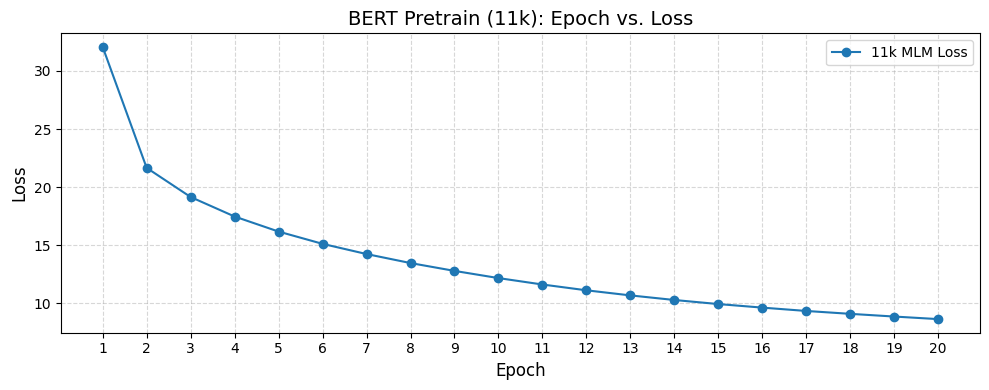

In [31]:
# 손실 값을 DataFrame으로 정리
df_11k = pd.DataFrame({
    "Epoch": list(range(1, len(train_losses_11k) + 1)),
    "Loss": train_losses_11k
})

# 표 형태로 손실 확인
display(df_11k)

# 손실 추이 시각화
plt.figure(figsize=(10, 4))
plt.plot(df_11k["Epoch"], df_11k["Loss"], marker='o', linestyle='-', label="11k MLM Loss")
plt.title("BERT Pretrain (11k): Epoch vs. Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(df_11k["Epoch"])
plt.legend()
plt.tight_layout()
plt.show()

이제 위 `추가 1. Fine-tuning을 위한 파일 전달`에서 했던 것과 같이,      fine-tuning 담당자가 Trainer로 모델을 불러올 수 있게 하기 위해   
config.json + pytorch_model.bin 구조의 폴더를 만들어봅시다.

In [30]:
# 전제:
# - vocab_11k: mini_emotion_tokenizer_11k.model 로드된 SentencePieceProcessor
# - config_11k: 11k BERT 학습에 사용된 Config
# - model_11k: 학습 완료된 BERTPretrain 인스턴스 (model_11k.bert 존재)

# 1. 저장할 폴더 경로 설정
output_dir = os.path.join(data_dir, "mini_bert_11k_hf")
os.makedirs(output_dir, exist_ok=True)

# 2. Hugging Face용 config.json 생성
config_11k_dict = dict(config_11k)
config_11k_dict["n_enc_vocab"] = vocab_11k.get_piece_size()

hf_config_11k = BertConfig(
    vocab_size=config_11k_dict["n_enc_vocab"],
    hidden_size=config_11k_dict["d_hidn"],
    num_hidden_layers=config_11k_dict["n_layer"],
    num_attention_heads=config_11k_dict["n_head"],
    intermediate_size=config_11k_dict["d_ff"],
    hidden_dropout_prob=config_11k_dict["dropout"],
    attention_probs_dropout_prob=config_11k_dict["dropout"],
    max_position_embeddings=config_11k_dict["n_enc_seq"],
    type_vocab_size=config_11k_dict["n_seg_type"],
    pad_token_id=config_11k_dict["i_pad"],
    layer_norm_eps=config_11k_dict["layer_norm_epsilon"]
)

hf_config_11k.save_pretrained(output_dir)

# 3. 가중치 저장 (encoder 부분만)
torch.save(
    model_11k.bert.state_dict(),
    os.path.join(output_dir, "pytorch_model.bin")
)

print(f"Hugging Face 형식 모델 저장 완료: {output_dir}")
print("  ├─ config.json")
print("  └─ pytorch_model.bin")

Hugging Face 형식 모델 저장 완료: /content/drive/MyDrive/bert/mini_bert_11k_hf
  ├─ config.json
  └─ pytorch_model.bin


## 추가 3. 7k 모델과 11k 모델로 Training 했을 때 결과 비교

앞서 진행한 두 가지 실험(`mini_emotion_tokenizer_7k.model` vs. `mini_emotion_tokenizer_11k.model`)의 학습 손실을 비교하여,
vocab 규모 확장이 BERT의 pretraining 성능에 어떤 영향을 주었는지 살펴봅니다.

두 모델 모두 동일한 데이터셋(`dair-ai/emotion`)과 동일한 학습 파라미터(learning rate, batch size, epoch 수)를 사용했으며,  
유일한 차이는 **토크나이저의 어휘 크기(vocab size)** 입니다.

- `7k 모델`: 어휘 수가 7,000개로, 상대적으로 압축된 단어 표현을 가짐  
- `11k 모델`: 어휘 수가 11,000개로, 세분화된 단어 표현을 제공

`df`(7k 손실)과 `df_11k`(11k 손실)을 비교하여 각 epoch별 손실 감소 추이를 확인하고,  
어떤 모델이 더 빠르게 수렴하거나 더 낮은 손실을 달성했는지를 분석해보았습니다.

분석의 초점은 다음과 같습니다.
1. **학습 수렴 속도** — 초기 epoch에서 손실이 얼마나 빠르게 줄어드는가?  
2. **최종 손실 값** — 마지막 epoch 기준으로 손실이 더 낮은 모델은 어느 쪽인가?  
3. **변동성(안정성)** — 손실 곡선이 얼마나 매끄럽게 수렴하는가?

이 비교를 통해, vocab 확장이 감정 데이터의 언어 표현 다양성을 얼마나 잘 포착했는지 평가합니다.  
결과적으로,  
- 만약 11k 모델의 손실이 더 낮고 안정적이라면 → **더 세밀한 표현력이 pretraining 성능을 향상시켰음**을 의미  
- 반대로 7k 모델이 비슷하거나 더 낮은 손실을 보인다면 → **데이터 규모 대비 vocab 확장이 오히려 불필요한 세분화를 초래했을 가능성**을 논의할 수 있습니다.

다음 코드에서는 두 모델의 학습 손실을 시각적으로 비교하여 이러한 차이를 정량적으로 확인합니다.

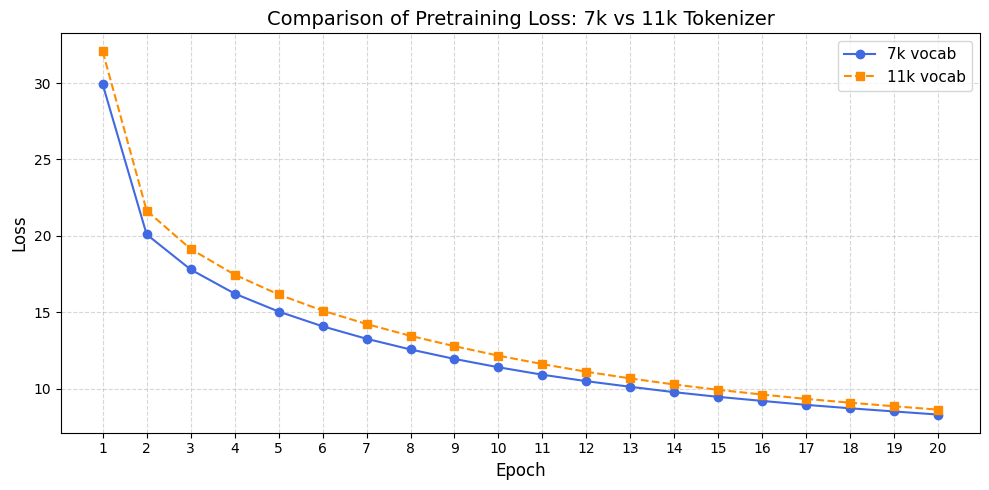

최종 Epoch 손실 비교:
 - 7k vocab 모델: 8.3155
 - 11k vocab 모델: 8.6366

7k vocab 모델이 더 낮은 손실을 보여, 11k 모델의 어휘 확장이 데이터 크기 대비 과적합 또는 희소화로 이어졌을 가능성이 있습니다.


In [32]:
plt.figure(figsize=(10, 5))
plt.plot(df["Epoch"], df["Loss"], marker='o', linestyle='-', color='royalblue', label="7k vocab")
plt.plot(df_11k["Epoch"], df_11k["Loss"], marker='s', linestyle='--', color='darkorange', label="11k vocab")

plt.title("Comparison of Pretraining Loss: 7k vs 11k Tokenizer", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=11)
plt.xticks(df["Epoch"])
plt.tight_layout()
plt.show()

# 두 모델의 마지막 손실 비교 요약 출력
final_7k = df["Loss"].iloc[-1]
final_11k = df_11k["Loss"].iloc[-1]

print(f"최종 Epoch 손실 비교:")
print(f" - 7k vocab 모델: {final_7k:.4f}")
print(f" - 11k vocab 모델: {final_11k:.4f}")

if final_11k < final_7k:
    print("\n11k vocab 모델이 더 낮은 손실로 수렴하였으므로, 어휘 확장이 표현력을 높여 성능이 향상된 것으로 보입니다.")
elif final_11k > final_7k:
    print("\n7k vocab 모델이 더 낮은 손실을 보여, 11k 모델의 어휘 확장이 데이터 크기 대비 과적합 또는 희소화로 이어졌을 가능성이 있습니다.")
else:
    print("\n두 모델의 손실이 거의 동일하므로, vocab 확장이 성능에 큰 영향을 주지 않은 것으로 보입니다.")